# Credit Card Fraud Detection
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

## Description of data

- The datasets contains transactions made by credit cards in September 2013 by european cardholders.
- This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.
- The dataset is highly <b>unbalanced</b>, the positive class (frauds) account for 0.172% of all transactions.
- It contains only numerical input variables which are the result of a PCA transformation. 
- Due to confidentiality issues, the original features and more background information about the data is not provided. 
- Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.
- The feature 'Amount' is the transaction Amount.
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Source: [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)

## Import required Libraries

In [8]:
# Install additional required packages
# !pip install xgboost 
# !pip install tabulate

In [9]:
import pandas as pd
import numpy as np

# For scaling the features and train-test split
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# For model buidling
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# For plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Custom module for prediction and model evalution
#from utils import predict_and_evaluate

In [10]:
# read data file
# this file is compressed in bzip2 format and index column is included in it
df = pd.read_csv('../CC.csv')

##  Undersand the data

In [11]:
df.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,2,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,3,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,4,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,5,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [13]:
df.shape

(284807, 32)

In [14]:
df.isnull().sum() # Check Null Values!

Unnamed: 0    0
Time          0
V1            0
V2            0
V3            0
V4            0
V5            0
V6            0
V7            0
V8            0
V9            0
V10           0
V11           0
V12           0
V13           0
V14           0
V15           0
V16           0
V17           0
V18           0
V19           0
V20           0
V21           0
V22           0
V23           0
V24           0
V25           0
V26           0
V27           0
V28           0
Amount        0
Class         0
dtype: int64

In [15]:
df.columns

Index(['Unnamed: 0', 'Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8',
       'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
       'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'Amount', 'Class'],
      dtype='object')

In [16]:
# Check Distribution Of Label
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [17]:
# The classes are heavily skewed. This is problem that needs to be solved. How?
print('No Frauds', round(df['Class'].value_counts()[0],2), 'are normal transactions')
print('Frauds', round(df['Class'].value_counts()[1],2), 'are fraud')

No Frauds 284315 are normal transactions
Frauds 492 are fraud


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

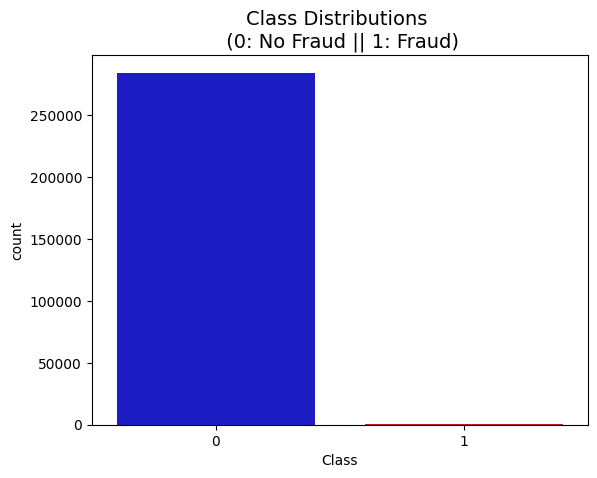

In [18]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

- Notice how imbalanced is our original dataset! 
- Most of the transactions are non-fraud. 
- If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. 
- But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

## Preprocessing - Scaling and Distribution
- We will first scale the columns comprise of <b>Time</b> and <b>Amount </b>. 
- Time and amount should be scaled as the other columns. 
- On the other hand, we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction is a fraud or not.

### What is a sub-Sample?
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

### Why do we create a sub-Sample?
We saw that the original dataframe is heavily imbalanced! Using the original dataframe  will cause the following issues:
<ul>
<li><b>Overfitting: </b>Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs. </li>
<li><b>Wrong Correlations:</b> Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features. </li>
</ul>

### Scaling

The **StandardScaler** assumes your data is normally distributed within each feature and will scale them such that the distribution is now centred around 0, with a standard deviation of 1. 

$$\frac{\text{x}-\text{mean}}{\text{standard deviation}}$$

The **MinMaxScaler** is the probably the most famous scaling algorithm, and follows the following formula for each feature. 

$$\frac{\text{x}-\text{min}}{\text{max}-\text{min}}$$

It essentially shrinks the range such that the range is now between 0 and 1 (or -1 to 1 if there are negative values). If the distribution is not Gaussian or the standard deviation is very small, the min-max scaler works better. However, it is sensitive to outliers, so if there are outliers in the data, you might want to consider the Robust Scaler below.

**Robust Scaler** scale features using statistics that are robust to outliers. The RobustScaler uses a similar method to the Min-Max scaler but it instead uses the interquartile range, rathar than the min-max, so that it is robust to outliers. 

$$\frac{\text{x}-\text{Q1(x)}}{\text{Q3(x)}-\text{Q1(x)}}$$

In [19]:
# Since most of our data has already been scaled, we will scale the columns that are not scaled (Amount and Time)
# RobustScaler is less prone to outliers.
rob_scaler = RobustScaler()

In [20]:
df['Amount'].values.reshape(-1,1)

array([[149.62],
       [  2.69],
       [378.66],
       ...,
       [ 67.88],
       [ 10.  ],
       [217.  ]])

In [21]:
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))

In [22]:
df.scaled_amount

0         1.783274
1        -0.269825
2         4.983721
3         1.418291
4         0.670579
            ...   
284802   -0.296653
284803    0.038986
284804    0.641096
284805   -0.167680
284806    2.724796
Name: scaled_amount, Length: 284807, dtype: float64

In [23]:
df.scaled_amount.describe()

count    284807.000000
mean          0.927124
std           3.495006
min          -0.307413
25%          -0.229162
50%           0.000000
75%           0.770838
max         358.683155
Name: scaled_amount, dtype: float64

In [24]:
df.drop(['Amount'], axis=1, inplace=True) # remove original time and Amount Columns from df

In [25]:
df.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount
0,1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274
1,2,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825
2,3,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721
3,4,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291
4,5,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579


In [26]:
# Rearranging the columns
scaled_amount = df['scaled_amount']

df.drop(['scaled_amount'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)

In [27]:
# Amount is Scaled!
df.head()

,scaled_amount,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,2,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,3,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,4,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,5,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


**EXERCISE:** Scale the Time Column

### Splitting the DataFrame

Before proceeding with any <b> Sampling technique</b> we have to separate the orginal dataframe.<br> 
<b> Why? for testing purposes, we want to test our models on the original testing set not on the testing set created by either of these techniques.</b><br> The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set. 

In [28]:
ss = StratifiedShuffleSplit(n_splits=1,
                            test_size=0.2,
                            train_size=0.8,
                            random_state=42)

In [29]:
X = df.drop('Class', axis=1)
y = df['Class']

In [30]:
for train_index, test_index in ss.split(X, y):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

In [31]:
train_index

array([265518, 180305,  42664, ...,  29062,  13766,  17677], dtype=int64)

In [32]:
test_index

array([263020,  11378, 147283, ..., 274532, 269819,  64170], dtype=int64)

In [33]:
df.iloc[train_index]

,scaled_amount,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
265518,-0.205128,265519,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,...,-0.134435,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,0
180305,-0.265633,180306,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,...,-0.227279,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,0
42664,2.139314,42665,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,...,1.280856,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,0
198723,-0.222176,198724,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,...,-0.490642,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,0
82325,0.895689,82326,59359.0,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,...,-0.275297,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233802,-0.223713,233803,147710.0,1.993864,-0.516866,-0.620118,0.129845,-0.285128,0.395044,-0.822358,...,-0.174051,0.262526,0.884510,0.099141,0.275689,-0.195404,0.623598,-0.032455,-0.058552,0
85418,0.209460,85419,60764.0,-1.497933,0.657921,1.581568,-0.024286,0.584698,1.303031,0.609212,...,-0.225079,-0.072452,0.299172,0.110048,-0.615980,-0.425883,0.263968,-0.448445,0.045178,0
29062,0.327255,29063,35301.0,1.069777,0.072105,0.496540,1.505318,-0.380277,-0.370243,0.100551,...,-0.149402,-0.061991,-0.044629,-0.050485,0.400171,0.593314,-0.335160,0.031014,0.024886,0
13766,-0.294977,13767,24413.0,1.280465,0.300586,0.333044,0.512720,0.065052,-0.145844,-0.145519,...,-0.093783,-0.409934,-0.961351,0.033153,-0.560429,0.278428,0.089546,-0.059835,-0.005887,0


In [34]:
train_df.shape

(227845, 32)

In [35]:
test_df.shape

(56962, 32)

In [36]:
print('Distributions: \n')
print("Train Set")
print(train_df.Class.value_counts())
print("\nTest Set")
print(test_df.Class.value_counts())
print("\nPercentage:")
print("\nTrain Set")
print((train_df.Class.value_counts()/ len(train_df))*100)
print("\nTest Set")
print((test_df.Class.value_counts()/ len(test_df))*100)

Distributions: 

Train Set
0    227451
1       394
Name: Class, dtype: int64

Test Set
0    56864
1       98
Name: Class, dtype: int64

Percentage:

Train Set
0    99.827075
1     0.172925
Name: Class, dtype: float64

Test Set
0    99.827955
1     0.172045
Name: Class, dtype: float64


### Random Under-Sampling:

Implement *"Random Under Sampling"* which basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

**Steps:**
<ul>
<li>The first thing we have to do is determine how <b>imbalanced</b> is our class (use "value_counts()" on the class column to determine the amount for each label)  </li>
<li>Once we determine how many instances are considered <b>fraud transactions </b> (Fraud = "1") , we should bring the <b>non-fraud transactions</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.  </li>
<li> After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to <b>shuffle the data</b> to see if our models can maintain a certain accuracy everytime we run this script.</li>
</ul>

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (randomly picking 394 non-fraud transaction  from 2,27,451 non-fraud transactions)

In [37]:
# Lets shuffle the data before creating the subsamples
train_df = train_df.sample(frac=1)

In [38]:
train_df

,scaled_amount,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
13341,1.592818,13342,23535.0,0.919391,-0.358937,0.163997,0.195361,-0.118717,0.170339,-0.082684,...,0.095272,0.010106,0.038430,-0.090397,-0.254736,0.139015,1.027888,-0.113085,-0.000992,0
144461,1.858311,144462,86142.0,0.976459,0.124219,0.278652,2.263769,0.272891,0.486166,0.198848,...,0.298372,-0.195539,-0.907044,-0.167065,-1.016435,0.357505,-0.192691,-0.015306,0.048689,0
92414,-0.269825,92415,63922.0,0.043455,0.985073,0.520996,0.713213,0.635452,-0.449527,1.137316,...,0.206712,0.078524,0.799022,0.000950,0.201554,-0.887311,-0.463935,0.222951,-0.168614,0
87322,0.499406,87323,61634.0,1.103299,-0.067842,0.158375,0.686546,-0.551064,-1.053346,0.183233,...,-0.170515,0.010422,-0.121390,0.017268,0.610278,0.317656,0.470297,-0.065593,0.011498,0
7538,-0.146720,7539,10311.0,0.364827,0.184528,1.767462,0.534418,-0.413319,-0.083546,-0.163918,...,-0.122299,-0.230930,-0.122954,0.089885,-0.030256,-0.674837,0.133205,-0.200304,-0.291796,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95292,-0.307413,95293,65242.0,-0.631701,1.049422,1.452194,2.576940,0.534141,-0.231687,0.583737,...,-0.029957,0.191249,0.602310,0.204187,0.418955,-0.307745,0.082757,-0.193404,0.147585,0
14180,1.376790,14181,25213.0,-0.493876,0.684138,1.844956,0.816149,-0.620155,-0.248437,1.257436,...,-0.067721,-0.006462,0.332250,-0.181242,0.718239,0.201906,-0.386271,-0.162314,-0.190629,0
19421,-0.232236,19422,30264.0,-0.314496,1.205763,1.164643,-0.033338,0.294177,-0.743782,0.794121,...,0.202264,-0.273375,-0.660949,-0.069127,0.005213,-0.073130,0.090236,0.252157,0.097157,0
198102,0.661217,198103,132333.0,1.908849,-0.040217,-1.670517,0.474229,0.157995,-1.093715,0.269766,...,0.010637,-0.200780,-0.378622,0.107054,-0.249158,-0.039482,-0.086242,-0.007004,-0.010389,0


In [39]:
# amount of fraud classes 394 rows
fraud_df = train_df.loc[train_df['Class'] == 1]
non_fraud_df = train_df.loc[train_df['Class'] == 0][:394]

In [40]:
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

In [41]:
# As fraud_df and non_fraud_df are concatenated, Shuffle dataframe rows to mix the rows
df2 = normal_distributed_df.sample(frac=1, random_state=42)

In [42]:
df2.shape

(788, 32)

In [43]:
df2.head()

,scaled_amount,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
153758,0.384266,153759,100000.0,-1.408633,-1.624698,2.547742,0.385672,0.502790,0.507195,-1.744431,...,0.209033,0.217641,0.758247,0.281254,0.736608,-0.741402,0.255350,0.141944,0.228167,0
154633,0.000559,154634,102318.0,-1.020632,1.496959,-4.490937,1.836727,0.627318,-2.735569,-1.546274,...,0.443489,0.773631,0.860618,-0.304666,-0.155500,0.412166,-0.220080,0.392338,-0.020089,1
15166,1.089779,15167,26523.0,-18.474868,11.586381,-21.402917,6.038515,-14.451158,-4.146524,-14.856124,...,1.577924,1.741136,-1.251138,-0.396219,0.095706,1.322751,-0.217955,1.628793,0.482248,1
57470,-0.296793,57471,47923.0,0.364377,1.443523,-2.220907,2.036985,-1.237055,-1.728161,-2.058582,...,0.310980,0.402730,-0.132129,-0.032977,0.460861,0.560404,0.409366,0.539668,0.296918,1
45203,-0.293440,45204,42247.0,-2.524012,2.098152,-4.946075,6.456588,3.173921,-3.058806,-0.184710,...,-0.162797,0.027935,0.220366,0.976348,-0.290539,1.161002,0.663954,0.456023,-0.405682,1


###  Equally Distributing 
<a id="correlating"></a>
Now that we have our dataframe correctly balanced, we can go further with our <b>analysis</b> and <b>data preprocessing</b>.

In [44]:
print('Distribution of the Classes in the subsample dataset')
print(df2['Class'].value_counts()/len(df2))

Distribution of the Classes in the subsample dataset
0    0.5
1    0.5
Name: Class, dtype: float64


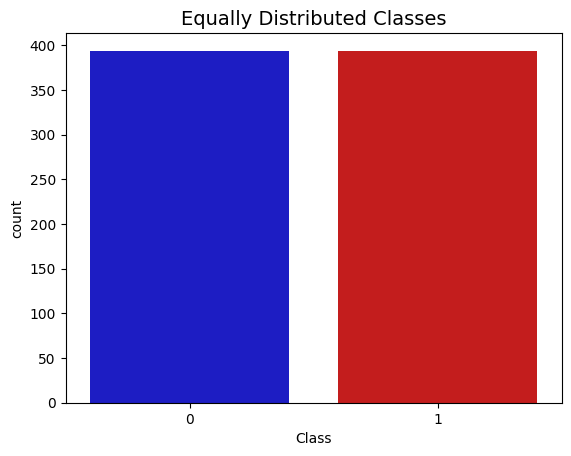

In [45]:
colors = ["#0101DF", "#DF0101"]
sns.countplot(x='Class', data=df2, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

## Training the ML Model for Fraud Detection(Classification) 

In [46]:
# Create X_train, X_test, y_train, y_test for ease of use
X_train = df2.drop('Class', axis=1)
y_train = df2['Class']

X_test = test_df.drop('Class', axis=1)
y_test = test_df['Class']

### Random Forest

In [47]:
rf_clf = RandomForestClassifier(n_estimators=100, criterion="entropy")

In [48]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy')

In [49]:
# Decision Tree in the Forest
rf_clf.estimators_[0]

DecisionTreeClassifier(criterion='entropy', max_features='sqrt',
                       random_state=909181773)

#### Evaluation Metrics
The Given the class imbalance ratio, Confusion matrix and accuracy is not meaningful
for unbalanced classification. A robust evaluation is required to measure the
performance of a fraud detection model.

**1. False Positives:**
A false positive is an outcome where the model incorrectly predicts the positive class.
<br>**2. False Negatives:**
A false negative is an outcome where the model incorrectly predicts the negative class.
<br>**3. Precision:**
Precision talks about how precise/accurate the model is i.e. out of those predicted positives, how many of them are actual positive. Precision is a good measure to determine, when the costs of False Positives is high. For instance, here, a false positive means that a transaction is that is non- fraudulent has been identified as fraudulent. This can happen if the precision is not high for the fraud detection model.
<br>**4. Recall:**
Recall calculates how many of the Actual Positives our model captures through labeling it as Positive (True Positive). If a fraudulent transaction is predicted as non-fraudulent (Predicted Negative), the consequence can be very bad for the bank.
<br>**5. F1 Score:**
F1 Score is used to seek a balance between Precision and Recall.
<br>**6. Mathews Correlation Coefficient:**
The coefficient takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient between the observed and predicted binary classifications; it returns a value between −1 and +1.<br> 
A coefficient of +1 represents a perfect prediction, 0 no better than random prediction and −1 indicates total disagreement between prediction and observation.<br>
The Matthews correlation coefficient is more informative than F1 score and
accuracy in evaluating binary classification problems, because it takes into
account the balance ratios of the four confusion matrix categories (true
positives, true negatives, false positives, and false negative).

In [50]:
rf_res = predict_and_evaluate(rf_clf, X_test, y_test)

NameError: name 'predict_and_evaluate' is not defined

In [ ]:
rf_res

# Feature Importances

In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables.

In [ ]:
rf_clf.feature_importances_

In [ ]:
X_train.columns

In [ ]:
feature_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)

In [ ]:
feature_importances.sort_values(ascending=False, inplace=True)

In [ ]:
feature_importances

In [ ]:
feature_importances

In [ ]:
fig = plt.figure(figsize=(8,4), dpi=100)
feature_importances.plot.bar()
plt.title("Feature importances")
plt.xlabel("Features")
plt.ylabel("Mean Decrease in Impurity")
plt.show()

## Exercise
Train all models again by considering only important features (e.g. top 10 or 20) and evaluate the model and observe the difference in the metrics.

### Gradient Boosting

In [ ]:
gbm_clf = GradientBoostingClassifier()

In [ ]:
gbm_clf.fit(X_train,y_train)

In [ ]:
gbm_res = predict_and_evaluate(gbm_clf, X_test, y_test)

### XGBoost

In [ ]:
xgb_clf = XGBClassifier()

In [ ]:
xgb_clf.fit(X_train,y_train)

In [ ]:
xgb_res = predict_and_evaluate(xgb_clf, X_test, y_test)

## Comparing the metrics for all models

In [ ]:
results = pd.DataFrame(data=[rf_res, gbm_res, xgb_res], 
             columns=('Algorithm','False Positives', 
                      'False Negatives', 'Precision', 
                      'Recall', 'F1 Score'))

In [ ]:
results